# VAE (not nan with 100 epochs and latent space 200)

In [2]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
ds = image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/raw_data/zelle', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2389 files belonging to 1 classes.


In [6]:
ds = ds.map(lambda x: x/255)
# ds = ds.map(lambda x: (x, x))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
imgs = ds.as_numpy_iterator().__next__()

In [7]:
imgs.shape

NameError: ignored

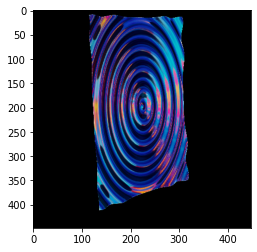

In [9]:
plt.imshow(imgs[0])


In [10]:
X_train = ds.map(lambda x : x/255).batch(16).prefetch(tf.data.AUTOTUNE)

In [11]:
from keras.layers import Lambda

In [12]:
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

In [13]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
latent_dim = 200


input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dim, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [15]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*64, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)


    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")
decoder.summary()
    

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      1475

In [17]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [18]:
ds

<MapDataset element_spec=TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None)>

In [19]:
#next_images = ds.as_numpy_iterator().__next__()

In [20]:
#vae.decoder(vae.encoder(next_images[0].reshape(-1,448,448,3))[0])

In [21]:
class CallbackSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.model.save_weights(f'/home/jupyter/model_{epoch}')

save_model = CallbackSaveModel()

In [23]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
#vae.load_weights('model_10')
vae.fit(ds, epochs=10, callbacks=[save_model])

Epoch 1/10
150/150 [==============================] - 44s 225ms/step - loss: 28817.4714 - reconstruction_loss: 27082.5508 - kl_loss: 230.7144
Epoch 2/10
150/150 [==============================] - 30s 192ms/step - loss: 24487.1702 - reconstruction_loss: 24454.8730 - kl_loss: 229.7722
Epoch 3/10
150/150 [==============================] - 30s 194ms/step - loss: 23319.2504 - reconstruction_loss: 23404.1680 - kl_loss: 248.4416
Epoch 4/10
150/150 [==============================] - 31s 203ms/step - loss: 22568.3010 - reconstruction_loss: 22851.6484 - kl_loss: 237.6883
Epoch 5/10
150/150 [==============================] - 30s 190ms/step - loss: 22208.2316 - reconstruction_loss: 22411.0781 - kl_loss: 239.4584
Epoch 6/10
150/150 [==============================] - 28s 178ms/step - loss: 21938.8722 - reconstruction_loss: 22220.7812 - kl_loss: 236.9891
Epoch 7/10
150/150 [==============================] - 31s 194ms/step - loss: 24439.3682 - reconstruction_loss: 24653.4805 - kl_loss: 3650.7954
Epoch

In [24]:
vae.save_weights('save_model_100epochs_200latdim')

In [25]:
#vae.load_weights('save_model_test2')load_weights

In [26]:
#vae.fit

In [27]:
#prediction = vae.predict(ds, verbose=0)

# Original Image

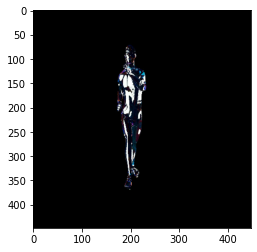

In [28]:
plt.imshow(imgs[5])

# VAE reconstructed image

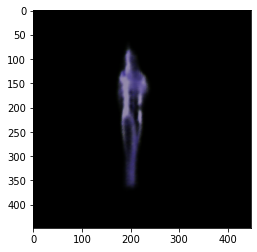

In [29]:
encoded_image = vae.encoder(imgs[5].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

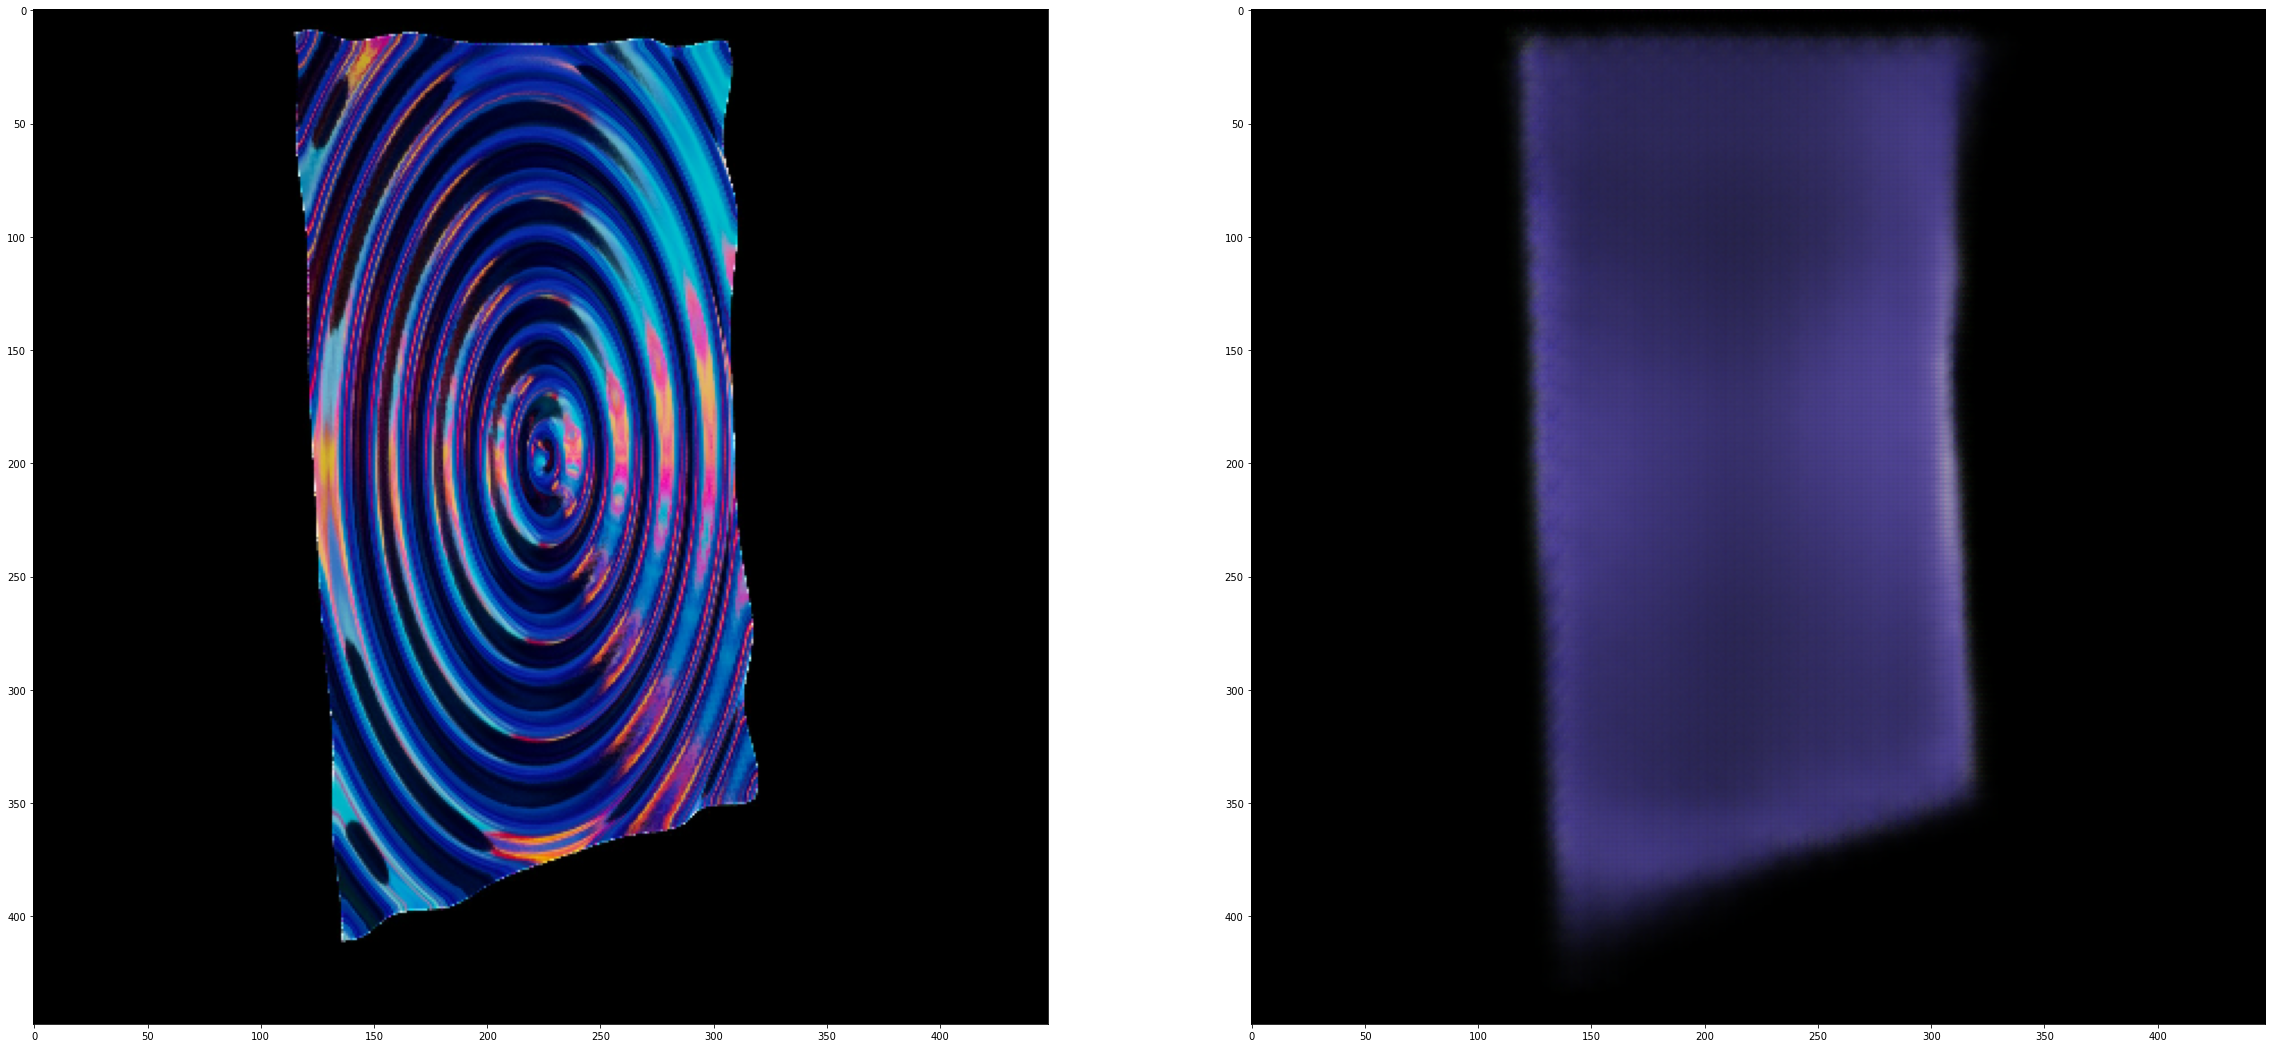

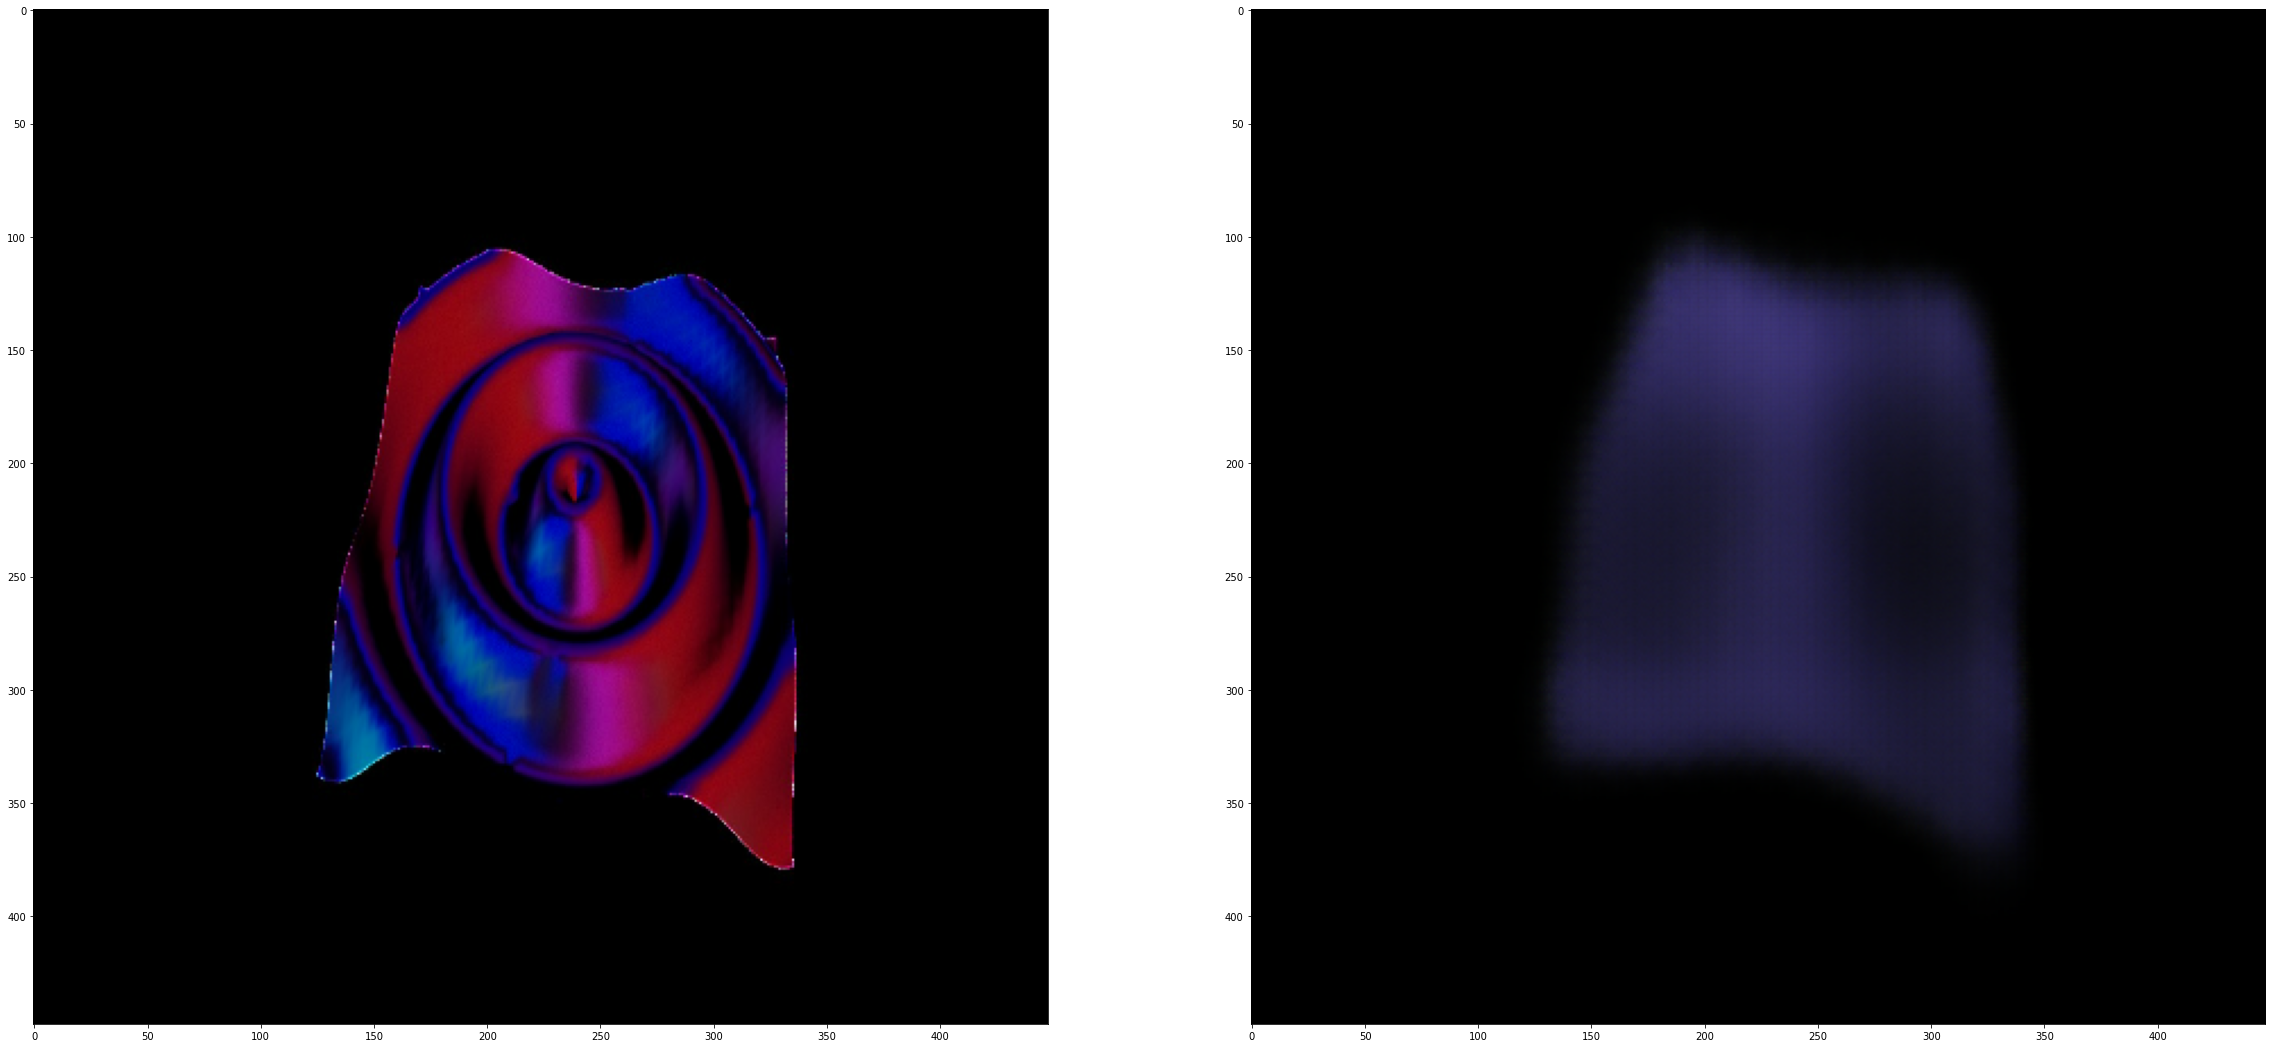

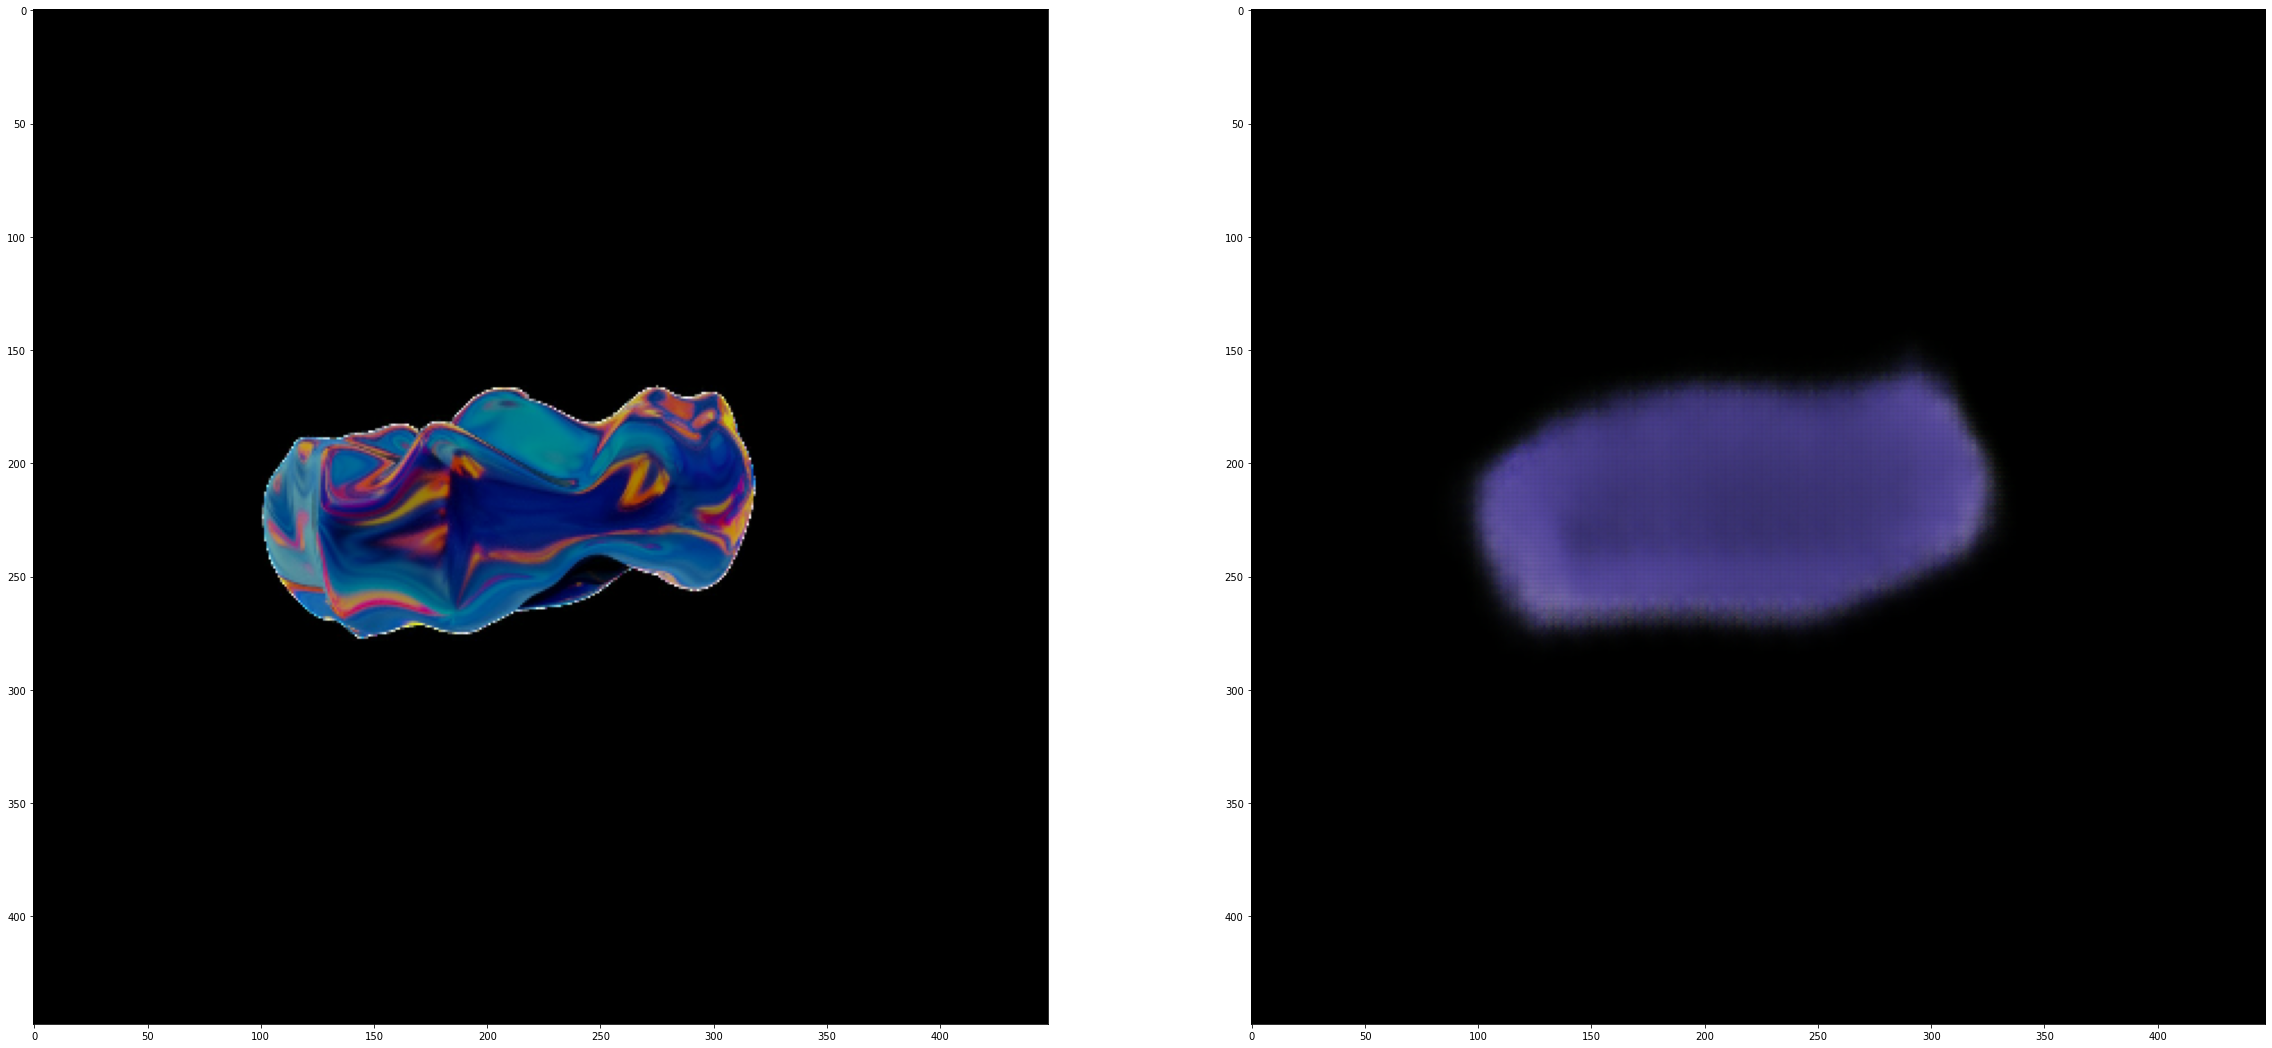

In [30]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    encoded_image = vae.encoder(imgs[i].reshape(-1,448,448,3))
    decoded_image = vae.decoder(encoded_image[0])
    ax2.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))
    ax1.imshow(imgs[i])

In [269]:
import librosa
y, sr = librosa.load('Drums.wav')
onset_env = librosa.onset.onset_strength(y=y, sr=24)
len(onset_env)
times = librosa.times_like(onset_env, sr=24)
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='time')
len(onset_frames)

N_STEPS = 100
frames_per_second= 24
sample_rate = 1/24
audio_movement = []

#image 3 and 1000
encoded_images = vae.encoder(imgs[10:12].reshape(-1,448,448,3))
decoded_images = vae.decoder(encoded_images[0])


In [270]:
onset_env.shape

(360,)

In [280]:




step_vec = (end_lat_vec - start_lat_vec ) / N_STEPS
interpolation_images = []

for i in range(0, N_STEPS):
    interpolation_images.append(start_lat_vec + (i * (step_vec *(onset_env[i]*1000))))
    #print(onset_env[i])




    
interp_array = np.array(interpolation_images)
interp_array.shape
#type(interp_array)


(100, 200)

In [272]:
# # Generate a series of points in the latent space
# interp_latent = start_lat_vec + (np.arange(N_STEPS)[:, np.newaxis] * step_lat_vec)


# # Generate images corresponding to each interpolated point
# inter_images = []
# for i in range(N_STEPS):
#     # Calculate onset envelope factor
#     onset_factor = onset_env[int(i * frame_per_second)] / onset_env.max()

#     # Modify step vector in the latent space using onset factor
#     mod_step_lat_vec = step_lat_vec * onset_factor

#     # Calculate interpolated point in the latent space using modified step vector
#     interp_latent_i = start_lat_vec + (i * mod_step_lat_vec)

#     # Decode interpolated point into image
#     interp_image_i = vae.decoder.predict(np.array([interp_latent_i]))

#     # Convert image to uint8 format
#     interp_image_i = (interp_image_i * 255).astype('uint8')

#     inter_images.append(interp_image_i)


In [273]:
start_lat_vec, end_lat_vec = encoded_images[0][0], encoded_images[0][1]
start_lat_vec.shape, end_lat_vec.shape

(TensorShape([200]), TensorShape([200]))

In [274]:



# audio_time = librosa.get_duration(y=y)
# int_1_ms = audio_time*1000
# audio_N_STEPS_ms = 1/frames_per_second * 1000
# step_time = int_1_ms/audio_N_STEPS_ms
# interpolation_images_and_audio = []
# for n in range(0, N_STEPS):
#     audio_movement.append(start_lat_vec + (i * step_vec))
# interp_array = np.array(interpolation_images)


In [275]:
encoded_images[0].shape

TensorShape([2, 200])

In [276]:
#inter_images_encoded = vae.encoder(interp_array).reshape(-1,448,448,3)
inter_images_decoded = vae.decoder(interp_array)

inter_images = (inter_images_decoded.numpy() * 255).astype('uint8')


In [225]:


for i in range(inter_images.shape[0]):
    im = Image.fromarray(inter_images[i])
    im.save(f'./images/image_{i}.jpg')

In [277]:
def make_gif(frame_folder):
    im_paths = [f'{frame_folder}/image_{i}.jpg' for i in range(100)]
    frames = [Image.open(image) for image in im_paths]
    
    frame_one = frames[0]
    frame_one.save(
        'sb-gif-test11.gif', 
        format='GIF', 
        append_images=frames, 
        save_all=True,
        duration=100,
        loop=0
    )


In [279]:
make_gif('/content/images')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')